In [4]:
'''

GUILHERME LIMA DE SOUSA - 
ESTUDO DE CASO: TONELADAS TRANSPORTADAS EM FERROVIAS BRASILEIRAS
OBJETIVO: PREDIÇÃO USANDO RANDOMFORESTREGRESSOR

ENTRE EM CONTATO COMIGO NO LINKEDIN: 
www.linkedin.com/in/guilherme-lima-747355169

'''


import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns


##CONFIGURANDO NUMEROS COM 2 CASAS DECIMAIS
pd.set_option('Float_format','{:.2f}'.format)

## COMPILANDO ARQUIVOS DA PASTA
pasta = 'C:/Users/Guilh/OneDrive/Área de Trabalho/1-MATERIAIS DE ESTUDO/01 - DIVERSOS/01-RANDOMFOREST/1-ANTT_FERROVIAS/01-INPUT'
arquivos = glob.glob(os.path.join(pasta, '*.csv'))
base_original = pd.concat([pd.read_csv(i, sep=';', encoding='latin1') for i in arquivos], ignore_index = True)

## REMOVENDO PONTO DA COLUNA
base_original['TU'] = base_original['TU'].str.replace('.','',regex=False)
base_original['TKU'] = base_original['TKU'].str.replace('.','',regex=False)

## ALTERANDO FORMATAÇÃO DA COLUNA
base_original['TKU'] = base_original['TKU'].fillna(0)
base_original['TKU'] = base_original['TKU'].astype(float)
base_original['TU'] = base_original['TU'].astype(int)
base_original['TKU'] = base_original['TKU'].astype(int)
base_original['Mes_Ano'] = pd.to_datetime(base_original['Mes_Ano'], format='%m/%Y')

## CRIANDO COLUNAS
base_original['MÊS'] = base_original['Mes_Ano'].dt.month
base_original['ANO'] = base_original['Mes_Ano'].dt.year

#REMOVENDO DUPLICADOS E NULOS
base_original = base_original.drop_duplicates()

# VENDO A BASE
base_original.head(-5)

,Mes_Ano,Ferrovia,Mercadoria_ANTT,Estacao_Origem,UF_Origem,Estacao_Destino,UF_Destino,TU,TKU,MÊS,ANO
0,2006-01-01,EFC,Álcool,Itaqui Base Combustível,MA,Marabá,PA,184,136344,1,2006
1,2006-01-01,EFC,Bebidas e Vasilhames,Ponta da Madeira Pêra do Píer,MA,Imperatriz,MA,1636,999596,1,2006
2,2006-01-01,EFC,Cobre,Paraupebas,PA,Ponta da Madeira Cobre,MA,24461,21158765,1,2006
3,2006-01-01,EFC,Ferro Gusa,Açailândia,MA,Ponta da Madeira Pêra do Píer,MA,116272,60345168,1,2006
4,2006-01-01,EFC,Ferro Gusa,Marabá,PA,Ponta da Madeira Pêra do Píer,MA,205242,152700048,1,2006
...,...,...,...,...,...,...,...,...,...,...,...
148653,2023-04-01,RMS,Soja,Marialva,PR,D Pedro II,PR,179173,111120561,4,2023
148654,2023-04-01,RMS,Soja,Marialva,PR,São Francisco do Sul,SC,80527,58531527,4,2023
148655,2023-04-01,RMS,Soja,Maringa,PR,D Pedro II,PR,193917,126386870,4,2023
148656,2023-04-01,RMS,Soja,Maringa,PR,Rio Grande,RS,1710,3610735,4,2023


In [5]:
##############################          EDA (exploratory data analysis)          ##############################
###################################################################################

print('#########################################')
print('EDA - COLUNAS CATEGORICAS')
print('#########################################\n')

# LINHAS E COLUNAS, NULOS e TIPO ?
base_original.info()
print('----------------------------------')

# DUPLICADOS
if base_original.duplicated().sum() > 0:
    print(f'Total de linhas duplicadas e excluidas: {base_original.duplicated().sum()}')
    base_original.drop_duplicates(inplace=True)
else:
    print('Não há dados duplicados')
print('----------------------------------')

## COLUNAS CATEGORICAS
print('#########################################\n')
print('Representatividade das principais colunas')
print('----------------------------------')
print('---------- Ferrovias ----------')
print(base_original['Ferrovia'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Mercadoria_ANTT ----------')
print(base_original['Mercadoria_ANTT'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Estacao_Origem ----------')
print(base_original['Estacao_Origem'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Estacao_Destino ----------')
print(base_original['Estacao_Destino'].value_counts(normalize=True))
print('----------------------------------')
print('---------- UF_Origem ----------')
print(base_original['UF_Origem'].value_counts(normalize=True))
print('----------------------------------')
print('---------- UF_Destino ----------')
print(base_original['UF_Destino'].value_counts(normalize=True))
print('----------------------------------')

#########################################
EDA - COLUNAS CATEGORICAS
#########################################

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148629 entries, 0 to 148662
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Mes_Ano          148629 non-null  datetime64[ns]
 1   Ferrovia         148629 non-null  object        
 2   Mercadoria_ANTT  148629 non-null  object        
 3   Estacao_Origem   148629 non-null  object        
 4   UF_Origem        148629 non-null  object        
 5   Estacao_Destino  148629 non-null  object        
 6   UF_Destino       148629 non-null  object        
 7   TU               148629 non-null  int32         
 8   TKU              148629 non-null  int32         
 9   MÊS              148629 non-null  int64         
 10  ANO              148629 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2), object(6)
memory usage: 12.5+

#########################################
EDA COLUNAS NÚMERICAS
----------------------------------
          Mes_Ano Ferrovia       Mercadoria_ANTT  \
0      2006-01-01      EFC                Álcool   
1      2006-01-01      EFC  Bebidas e Vasilhames   
2      2006-01-01      EFC                 Cobre   
3      2006-01-01      EFC            Ferro Gusa   
4      2006-01-01      EFC            Ferro Gusa   
...           ...      ...                   ...   
148658 2023-04-01      RMS                  Soja   
148659 2023-04-01      RMS                  Soja   
148660 2023-04-01      RMS                  Soja   
148661 2023-04-01      RMS                  Soja   
148662 2023-04-01      RMS                 Ureia   

                       Estacao_Origem UF_Origem  \
0             Itaqui Base Combustível        MA   
1       Ponta da Madeira Pêra do Píer        MA   
2                          Paraupebas        PA   
3                          Açailândia        MA   
4                    

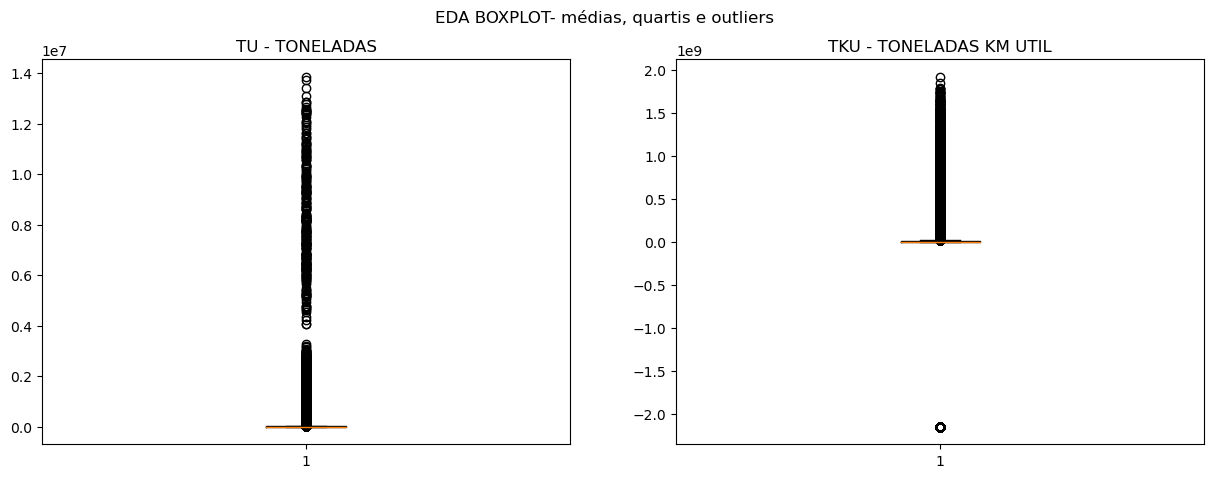

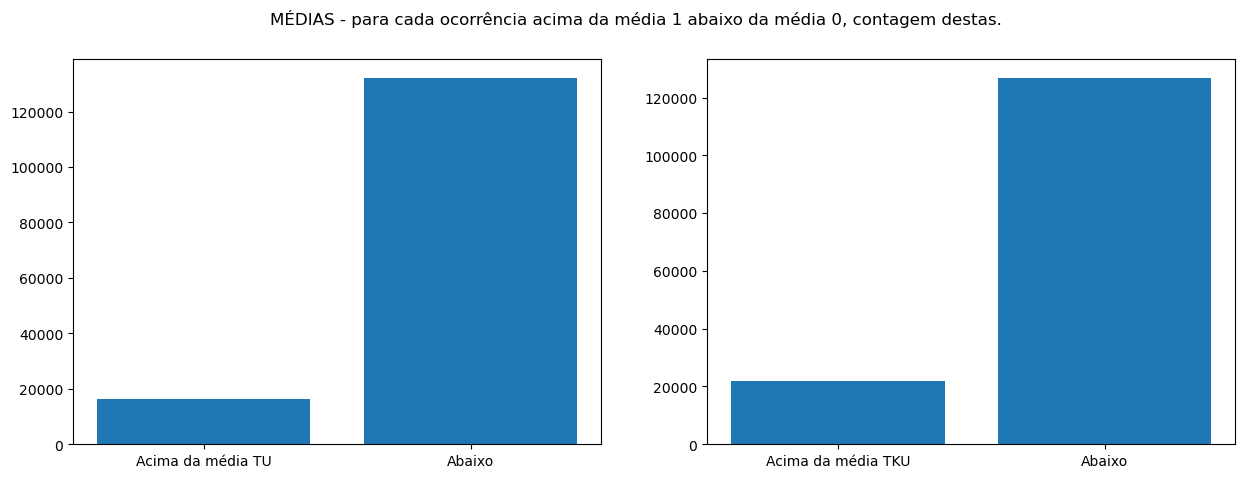

In [6]:
## COLUNAS NÚMERICAS
print('#########################################')
print('EDA COLUNAS NÚMERICAS')
print('----------------------------------')

figura = plt.figure(figsize=(15,5))
figura.suptitle('EDA BOXPLOT- médias, quartis e outliers')

figura.add_subplot(121)
plt.boxplot(base_original['TU'], showfliers=True)
plt.title('TU - TONELADAS')

figura.add_subplot(122)
plt.boxplot(base_original['TKU'], showfliers=True)
plt.title('TKU - TONELADAS KM UTIL')


######
#########################################

# CRIANDO UMA FLAG NA BASE ACIMA OU ABAIXO DA MEDIA
base_original['FLAG_MEDIA_TU'] = np.where(base_original['TU'] >= base_original['TU'].mean(),1,0)
base_original['FLAG_MEDIA_TKU'] = np.where(base_original['TKU'] >= base_original['TKU'].mean(),1,0)
print(base_original)


figura_2 = plt.figure(figsize=(15,5))
figura_2.suptitle('MÉDIAS - para cada ocorrência acima da média 1 abaixo da média 0, contagem destas.')


figura_2.add_subplot(121)
acima_tu = base_original[base_original['FLAG_MEDIA_TU'] == 1]['FLAG_MEDIA_TU'].count()
abaixo_tu = base_original[base_original['FLAG_MEDIA_TU'] == 0]['FLAG_MEDIA_TU'].count()
plt.bar(['Acima da média TU', 'Abaixo'], [acima_tu, abaixo_tu])


figura_2.add_subplot(122)
acima_tku = base_original[base_original['FLAG_MEDIA_TKU'] == 1]['FLAG_MEDIA_TKU'].count()
abaixo_tku = base_original[base_original['FLAG_MEDIA_TKU'] == 0]['FLAG_MEDIA_TKU'].count()
plt.bar(['Acima da média TKU', 'Abaixo'], [acima_tku, abaixo_tku])


plt.show()


#########################################
EDA - FERROVIAS MAIS USADAS EM TONELADAS
----------------------------------


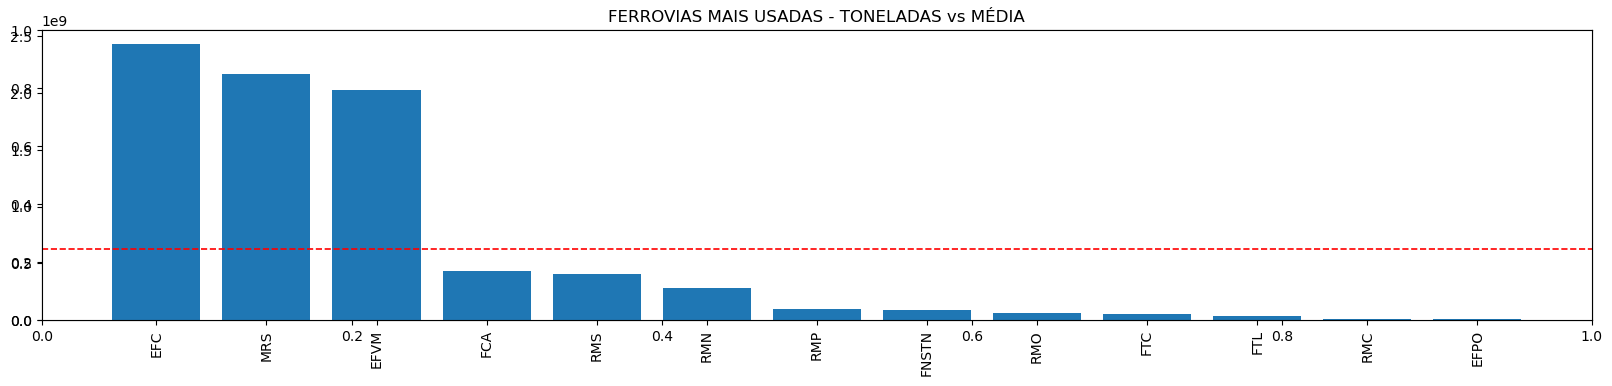

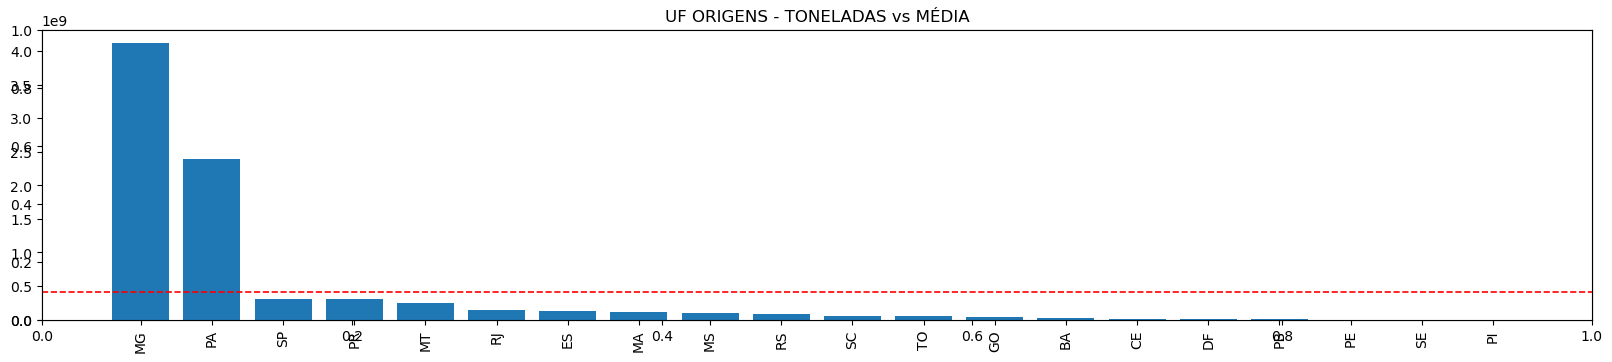

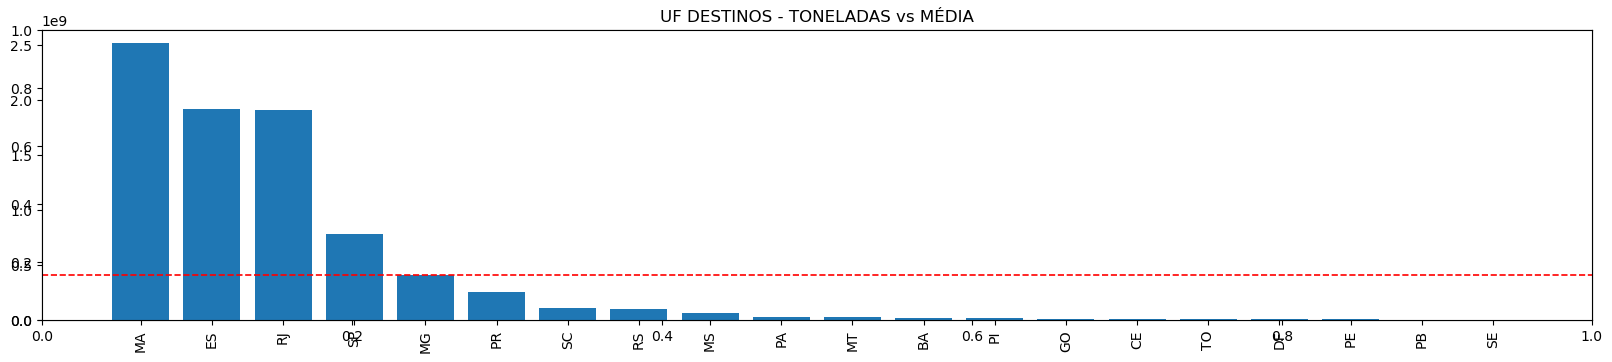

In [7]:
## DISTRIBUIÇÕES DE FREQUÊNCIA
print('#########################################')
print('EDA - FERROVIAS MAIS USADAS EM TONELADAS')
print('----------------------------------')

figura = plt.figure(figsize=(20,5))
plt.title('FERROVIAS MAIS USADAS - TONELADAS vs MÉDIA')


figura.add_subplot(111)
um = base_original.groupby('Ferrovia')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(um['Ferrovia'], um['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(um['TU']), color='red', linestyle='--', linewidth=1.2)



figura2 = plt.figure(figsize=(20,5))
plt.title('UF ORIGENS - TONELADAS vs MÉDIA')

figura2.add_subplot(111)
dois = base_original.groupby('UF_Origem')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(dois['UF_Origem'], dois['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(dois['TU']), color='red', linestyle='--', linewidth=1.2)





figura3 = plt.figure(figsize=(20,5))
plt.title('UF DESTINOS - TONELADAS vs MÉDIA')
figura3.add_subplot(111)
dois = base_original.groupby('UF_Destino')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(dois['UF_Destino'], dois['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(dois['TU']), color='red', linestyle='--', linewidth=1.2)




plt.show()
#teste.sort_values(by='TU', ascending=False)

In [18]:
'''

AQUI VAMOS CRIAR O DATASET DO MODELO

FAZENDO ETL COM AS COLUNAS CATEGORICAS E APLICANDO CÓDIGOS PARA CADA UMA, 
POSTERIORMENTE USANDO AS COLUNAS NUMERICAS REPRESENTADAS COMO VARIAVEIS DO MODELO.
EM VEZ DE USAR O NOME DA FERROVIA ESTAMOS USANDO UM CÓDIGO DISTINTO DELA.

'''




####################################################################################

#     CRIANDO DATASET DO MODELO RANDOMFOREST

####################################################################################


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from numpy import random


np.random.seed(0)


## BASE MODELO
#print(base_original.columns)
print('--------------------')
base_modelo = base_original

# DUMMIES
#base_modelo = pd.get_dummies(base_original)

# TRANSFORMANDO COLUNAS
base_modelo['ANO'] = base_modelo['ANO'].astype(int)
base_modelo['MÊS'] = base_modelo['MÊS'].astype(int)
base_modelo['TU'] = base_modelo['TU'].astype(int)
base_modelo['TKU'] = base_modelo['TKU'].astype(int)

#
# CRIANDO OS CÓDIGOS DE CADA CATEGORIA
categ = base_modelo.select_dtypes(include=['object', 'category']).copy()
cod_categorica_hoje_1 = categ.apply(lambda col: col.astype('category').cat.codes)
cod_categorica_1 = cod_categorica_hoje_1.add_prefix('Codigo_') 
codigos_categorias = pd.concat([base_modelo, cod_categorica_1], axis=1)


## BASE FINAL MODELO
base_cenario_1 = codigos_categorias.select_dtypes(exclude=['object', 'category']).copy()
base_cenario_1 = base_cenario_1.drop(columns=['Mes_Ano'])


# SELECIONANDO COLUNAS
categorias_fk = codigos_categorias.loc[:,['Ferrovia', 'Mercadoria_ANTT', 'Estacao_Origem',
                                                'UF_Origem', 'Estacao_Destino', 'UF_Destino', 
                                                'Codigo_Ferrovia', 'Codigo_Mercadoria_ANTT', 'Codigo_Estacao_Origem',
                                                'Codigo_UF_Origem', 'Codigo_Estacao_Destino', 'Codigo_UF_Destino']]



#DUPLICADOS
categorias_fk = categorias_fk.drop_duplicates()
base_cenario_1 = base_cenario_1.drop_duplicates()
base_cenario_1 = base_cenario_1.fillna(0)



# LIMITANDO A BASE REMOVENDO 2023
base_cenario_1 = base_cenario_1[base_cenario_1['ANO'] != 2023][list(base_cenario_1.columns)]


# OUTLIERS
q3 = base_cenario_1['TU'].quantile(0.75)
base_cenario_1 = base_cenario_1[base_cenario_1['TU'] <= q3]
base_modelo = base_cenario_1

print(' O ano maximo dataset de treino é:', {base_modelo['ANO'].max()})
print('##################################################')
print(' Colunas da base final:', base_modelo.columns)
print('##################################################')
print(' Head base final:\n', base_modelo.head(3))
print('##################################################')
#print(' As informações do dataset:', categorias_fk.info())
#print('##################################################')
print(' Colunas da base FK:', categorias_fk.columns)
print('##################################################')
print(' Head base fk:\n', categorias_fk.head(3))
print('##################################################')


--------------------
 O ano maximo dataset de treino é: {2022}
##################################################
 Colunas da base final: Index(['TU', 'TKU', 'MÊS', 'ANO', 'FLAG_MEDIA_TU', 'FLAG_MEDIA_TKU',
       'Codigo_Ferrovia', 'Codigo_Mercadoria_ANTT', 'Codigo_Estacao_Origem',
       'Codigo_UF_Origem', 'Codigo_Estacao_Destino', 'Codigo_UF_Destino'],
      dtype='object')
##################################################
 Head base final:
      TU      TKU  MÊS   ANO  FLAG_MEDIA_TU  FLAG_MEDIA_TKU  Codigo_Ferrovia  \
0   184   136344    1  2006              0               0                0   
1  1636   999596    1  2006              0               0                0   
5  8000  1752000    1  2006              0               0                0   

   Codigo_Mercadoria_ANTT  Codigo_Estacao_Origem  Codigo_UF_Origem  \
0                      98                    216                 5   
1                      11                    316                 5   
5                     

In [20]:

'''

HIPÓTESE NULA = SERÁ QUE MEU MODELO CONSEGUE EXPLICAR AS TONELADAS TRANSPORTADAS
APENAS COM AS DEMAIS COLUNAS DO NOSSO DATASET ?


MODELO COM VALIDAÇÃO CRUZADA DE 5 FOLDS CRIADO COM OS PARAMETROS:

MAXDEPTH = 5 
PERMITE CRIAR ARVORES MAIS PROFUNDAS E TRAZ ALEATORIEDADE AOS DADOS, GENERALIZAÇÃO.

N_ESTIMATORS = 10
10 ARVORES DE DECISÃO NO MÁXIMO

RANDOM_STATE = 2
REPLICABILIDADE DE RESULTADOS

'''


############################################################################


#  CIRANDO O MODELO E APLICANDO NA BASE DE TREINO

############################################################################


# DEFININDO X (VAR DEPENDENTE) Y (VAR TARGET)
x = base_modelo.drop(columns=['TU'])
y = base_modelo['TU']

print('\nVERIFICANDO O AJUSTE')
maximo_x = base_modelo['ANO'].max()
print(maximo_x)
print('--------- ----------')
print(base_modelo.info())

# SEPARANDO TREINO E TESTE
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1)

# CRIANDO MODELO (10 arvores, profundidade 5, replicabilidade seed 2)
modelo = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=2)

# VALIDAÇÃO CRUZADA
kf = KFold(n_splits=5, shuffle= True, random_state=2)
cross_validation = cross_val_score(modelo, x, y, cv=kf, scoring='r2')

# APLICANDO LOG() PARA MELHORAR A DISTRIBUIÇÃO DO MODELO - evita heterocedasticidade
#y_train_log = np.log1p(y_train)


# TREINANDO O MODELO
modelo.fit(x_train, y_train)


# PREVER NO COJUNTO DE TESTE
y_pred_test = modelo.predict(x_test)
#y_pred = np.expm1(y_pred_test)

# R2 NO CONJUNTO DE TESTE
r2_test = r2_score(y_test, y_pred_test)


########## RESULTADOS VALIDAÇÃO CRUZADA
print('----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------')
print(f"O tipo do modelo carregado é: {type(modelo)}")
print(f"R2 para cada fold (cross-validation): {cross_validation}")
print(f"R2 média (cross-validation): {cross_validation.mean()*100}")
print(f"Desvio padrão cada KFold (cross validation): {cross_validation.std()}")
print(f"R² no conjunto de teste: {r2_test:.2f}")


###################################################################

#   SALVANDO MODELO

###################################################################


from joblib import dump, load

print('----------  SALVANDO MODELO DOIS  ----------')
dump(modelo,'ANTT_RANDOMFORESTREGRESSOR.joblib')


VERIFICANDO O AJUSTE
2022
--------- ----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 109570 entries, 0 to 146127
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   TU                      109570 non-null  int32
 1   TKU                     109570 non-null  int32
 2   MÊS                     109570 non-null  int32
 3   ANO                     109570 non-null  int32
 4   FLAG_MEDIA_TU           109570 non-null  int32
 5   FLAG_MEDIA_TKU          109570 non-null  int32
 6   Codigo_Ferrovia         109570 non-null  int8 
 7   Codigo_Mercadoria_ANTT  109570 non-null  int8 
 8   Codigo_Estacao_Origem   109570 non-null  int16
 9   Codigo_UF_Origem        109570 non-null  int8 
 10  Codigo_Estacao_Destino  109570 non-null  int16
 11  Codigo_UF_Destino       109570 non-null  int8 
dtypes: int16(2), int32(6), int8(4)
memory usage: 4.2 MB
None
----------  RESULTADOS VALIDAÇÃO CRUZADA  ---------

['ANTT_RANDOMFORESTREGRESSOR.joblib']

In [21]:

'''
AQUI APLICAMOS O MODELO NO CENARIO FICTICIO PARA VER COMO ELE GENERALIZA COM OS DADOS EM UM CENÁRIO
DESCONHECIDO

'''


###################################################################

# APLICANDO MODELO NO CENARIO FICTÍCIO

###################################################################

np.random.seed(2)

dataset_inicial = base_original

# DUMMIES
#base_modelo = pd.get_dummies(base_original)

# TRANSFORMANDO COLUNAS
dataset_inicial['ANO'] = dataset_inicial['ANO'].astype(int)
dataset_inicial['MÊS'] = dataset_inicial['MÊS'].astype(int)
dataset_inicial['TU'] = dataset_inicial['TU'].astype(int)
dataset_inicial['TKU'] = dataset_inicial['TKU'].astype(int)

#
# CODIGOS CATEGORIAS
codigos_categorias_dataset_inicial = pd.merge(dataset_inicial, categorias_fk, how='inner', on=['Ferrovia','Mercadoria_ANTT','Estacao_Origem','UF_Origem','Estacao_Destino','UF_Destino'])
#codigos_categorias_dataset_inicial.head()



## BASE FINAL MODELO
base_cenario = codigos_categorias_dataset_inicial.select_dtypes(exclude=['object', 'category']).copy()
base_cenario = base_cenario.drop(columns=['Mes_Ano'])




#DUPLICADOS
base_cenario = base_cenario.drop_duplicates()
base_cenario = base_cenario.fillna(0)



# LIMITANDO A BASE PARA 2023
base_cenario = base_cenario[base_cenario['ANO'] == 2023][list(base_cenario.columns)]


# OUTLIERS
q3 = base_cenario['TU'].quantile(0.75)
base_cenario = base_cenario[base_cenario['TU'] <= q3]




print(' O ano minimo é:', {base_cenario['ANO'].min()})
print('##################################################')
print(' Colunas da base final:', base_cenario.columns)
print('##################################################')
print(' Colunas da base FK:', categorias_fk.columns)
print('##################################################')


############################################################################

# APLICANDO MODELO


############################################################################


# CARREGANDO MODELO
modelo_cenario = load('ANTT_RANDOMFORESTREGRESSOR.joblib')

##CRIANDO A BASE DO ML UTILIZANDO O STATUS EM BINARIO
cenario_um_completo = base_cenario.drop(columns=['TU'])
cenario_um_target = base_cenario['TU'].values

#FAZENDO AS PREVISOES NO CONJUNTO DE TESTE
pred_cenario_um = modelo_cenario.predict(cenario_um_completo)
acuracia_cenario_um = r2_score(cenario_um_target, pred_cenario_um)

#RESULTADOS 
print("----------------- ACURACIAS DO MODELO NO CENÁRIO 1 -----------------------------------")
print(f"R2 no cenário 1: {acuracia_cenario_um*100:.2f}%")
print(f"R2 para cada fold: {acuracia_cenario_um}")
print(f"R2 média: {acuracia_cenario_um.mean()*100}")
print(f"Desvio padrão de R2  (cross validation): {acuracia_cenario_um.std()}")
print("---------------------Relatório de Classificação------------------------------")
print("MAE:", mean_absolute_error(cenario_um_target, pred_cenario_um))
print("RMSE:", mean_squared_error(cenario_um_target, pred_cenario_um, squared=False))
print("R²:", r2_score(cenario_um_target, pred_cenario_um))


'''
##########################################################

####  CENARIO COM MAX_DEPHT = 3

##########################################################

# ACURACIA 
consegue explicar cerca de 38,6% da variação da variável alvo (TU). Isso é melhor do que um chute aleatório, 
mas ainda distante de um bom ajuste (ideal: acima de 0,70 em muitos contextos). 
Pode indicar que variáveis importantes estão faltando ou que os dados têm muita variabilidade.


# ERRO ABSOLUTO MEDIO - (MAE mean absolute error)
Em média, o modelo erra cerca de 42.535 unidades na previsão de TU. Esse valor deve ser 
interpretado em relação à escala dos dados — se TU varia de 0 a milhões, 
esse erro pode ser tolerável; se não, pode ser alto.


# RMSE - Raiz do erro quadratico médio - (Raise mean squared error)
Esse erro penaliza mais fortemente grandes erros. Um RMSE muito maior que o MAE (como aqui) indica que 
há outliers ou erros muito grandes em alguns casos que estão influenciando bastante a performance.


# DESVIO PADRÃO 
O valor estar zerado é incomum. Pode indicar que todas as folds usaram dados muito parecidos (baixa variabilidade) ou que algo 
está errado no particionamento. 
Sugere verificar se x e y foram bem embaralhados ou se há algum viés nos dados.

##########################################################

####  CENARIO COM MAX_DEPHT = 5

##########################################################

# ACURACIA 
o modelo é capaz de explicar 87.47% da variabilidade dos dados, sugerindo que o modelo tem boa capacidade de generalização. 
A alta consistência entre os R² de cada fold (acima de 87%) também reforça a 
estabilidade do modelo durante a validação cruzada.
R2 para cada fold: 0.8747247421151431


# ERRO ABSOLUTO MEDIO - (MAE mean absolute error)
O MAE de 20.109 diz, em média, o modelo comete um erro de cerca de 20.109 unidades ao prever o 
valor de uma amostra. Esse valor é útil para entender o 
erro médio em termos absolutos, mas não penaliza erros grandes, o que pode ser uma limitação dependendo da aplicação.


# RMSE - Raiz do erro quadratico médio - (Raise mean squared error)
O RMSE de 117.912 é significativamente mais alto que o MAE, indicando que o modelo está cometendo erros 
mais elevados para algumas previsões, pois o RMSE penaliza erros grandes mais fortemente (por causa da elevação ao quadrado).
Isso pode ser indicativo de alguns outliers ou grandes desvios em algumas previsões.


# DESVIO PADRÃO
O desvio padrão de 0.0 é uma curiosidade, já que sugere que a performance do modelo foi extremamente consistente 
em todos os folds da validação cruzada, ou seja, o R² foi exatamente o mesmo para cada partição. 
Isso é incomum e pode indicar que a base de dados ou o modelo são bastante estáveis, 
mas também pode refletir dados homogêneos ou um modelo muito simples que não está aprendendo variações complexas.


###########################################################################################

PARAMETROS

###########################################################################################


# MAX_DEPTH
Quando eu uso max_depth=3 o modelo cria arvores mais curtas, quando eu uso max_depth=5 o modelo mais profundo.
esse ajuste na profundidade permite que as arvores aprendam melhor com padrões mais complexos.
um max_depth=3 obtem do conjunto de dados 38% de r2 .......quando max_depth=5 r2 vai para 87% ....devido o ajuste.
Por este motivo seguiremos com o ajuste de parametro definitivo para max_depth=5 trazendo mais profundidade.

# SHUFFLE
Outro parametro importante no quesito governança e replicabilidade. SHUFFLE = TRUE na validação cruzada (definindo 
os KFOLDs) ela realiza uma reorganização/aleatoriedade nos dados e 
só depois eles são divididos nas amostras das arvores.
Traz a segurança de que seus dados estão aleatoriamente espalhados entres as amostras, sem viés.


# VALIDAÇÃO CRUZADA
Tendo sido garantido o parametro de SHUFFLE = TRUE com a aleatoriedade e também devido aos resultados do 
modelo na base de treino terem o R2 para cada fold acima de 90: 
Acurácias para cada fold (cross-validation): [0.9796102  0.98267003 0.98128526 0.98012577 0.98185526]
Foi realizado uma verificação também no R2 do conjunto de teste, 
pois o modelo foi aplicado nele também e com um R2 = 98%.

Com isso consegue anular a hipotese de que há overffiting, pois os dados estão aleatorios e sua
variação está sendo compreendida pelo modelo dado ao resultado de 87% no cenario novo (bom) .... 
e 98% no conjunto de teste (bom).


'''



 O ano minimo é: {2023}
##################################################
 Colunas da base final: Index(['TU', 'TKU', 'MÊS', 'ANO', 'FLAG_MEDIA_TU', 'FLAG_MEDIA_TKU',
       'Codigo_Ferrovia', 'Codigo_Mercadoria_ANTT', 'Codigo_Estacao_Origem',
       'Codigo_UF_Origem', 'Codigo_Estacao_Destino', 'Codigo_UF_Destino'],
      dtype='object')
##################################################
 Colunas da base FK: Index(['Ferrovia', 'Mercadoria_ANTT', 'Estacao_Origem', 'UF_Origem',
       'Estacao_Destino', 'UF_Destino', 'Codigo_Ferrovia',
       'Codigo_Mercadoria_ANTT', 'Codigo_Estacao_Origem', 'Codigo_UF_Origem',
       'Codigo_Estacao_Destino', 'Codigo_UF_Destino'],
      dtype='object')
##################################################
----------------- ACURACIAS DO MODELO NO CENÁRIO 1 -----------------------------------
R2 no cenário 1: 65.19%
R2 para cada fold: 0.6519345919105356
R2 média: 65.19345919105356
Desvio padrão de R2  (cross validation): 0.0
---------------------Relatório

'\n##########################################################\n\n####  CENARIO COM MAX_DEPHT = 3\n\n##########################################################\n\n# ACURACIA \nconsegue explicar cerca de 38,6% da variação da variável alvo (TU). Isso é melhor do que um chute aleatório, \nmas ainda distante de um bom ajuste (ideal: acima de 0,70 em muitos contextos). \nPode indicar que variáveis importantes estão faltando ou que os dados têm muita variabilidade.\n\n\n# ERRO ABSOLUTO MEDIO - (MAE mean absolute error)\nEm média, o modelo erra cerca de 42.535 unidades na previsão de TU. Esse valor deve ser \ninterpretado em relação à escala dos dados — se TU varia de 0 a milhões, \nesse erro pode ser tolerável; se não, pode ser alto.\n\n\n# RMSE - Raiz do erro quadratico médio - (Raise mean squared error)\nEsse erro penaliza mais fortemente grandes erros. Um RMSE muito maior que o MAE (como aqui) indica que \nhá outliers ou erros muito grandes em alguns casos que estão influenciando bastante 

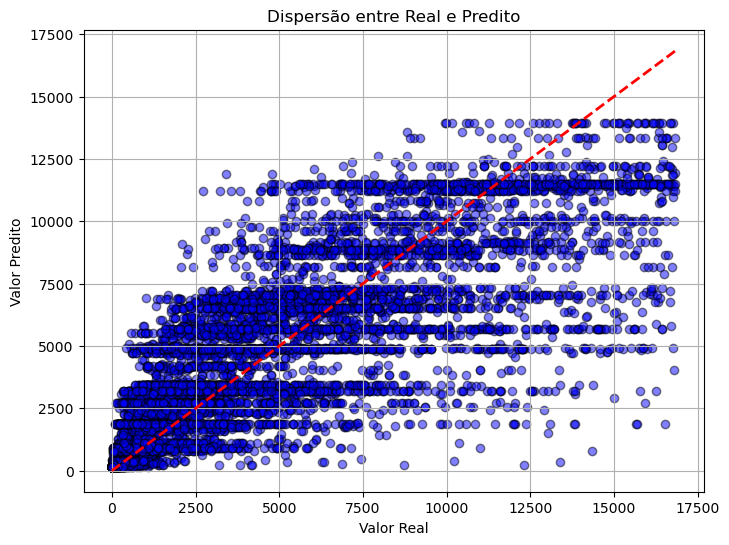

'\n\n## HOMOCEDASTICIDADE\nEm modelos de regressão, a homocedasticidade (erros com variância constante) é uma \nhipótese desejável, pois garante previsões mais estáveis e métricas mais confiáveis.\nSe há heterocedasticidade (o inverso), pode ser que o modelo:\n\n    Não esteja lidando bem com outliers ou valores altos.\n    Precise de uma transformação de escala (como log).\n    Precise ser avaliado com métricas específicas por faixa de valor.\n\nOs valores baixos do real (y_test), fazem os pontos mais agrupados e próximos da linha ideal.\nConforme o valor real (y_test) aumenta, os pontos se espalham mais em torno da linha — o erro aumenta também.\n\n\n## TRANSFORMAÇÃO COM LOG\nAo aplicarmos a transformação de log(1+x) a distribuição do dataset fica mais simetrica, trazendo suavidade e \nbalanceamento \n\n'

In [22]:
########################################################################

# GRAFICO REAL VS PREDITO


########################################################################

plt.figure(figsize=(8,6))

# Pontos: valor real vs valor predito
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue', edgecolors='k')

# Linha ideal (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', linewidth=2)

# Eixos e título
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Dispersão entre Real e Predito")
plt.grid(True)
plt.show()




'''

## HOMOCEDASTICIDADE
Em modelos de regressão, a homocedasticidade (erros com variância constante) é uma 
hipótese desejável, pois garante previsões mais estáveis e métricas mais confiáveis.
Se há heterocedasticidade (o inverso), pode ser que o modelo:

    Não esteja lidando bem com outliers ou valores altos.
    Precise de uma transformação de escala (como log).
    Precise ser avaliado com métricas específicas por faixa de valor.

Os valores baixos do real (y_test), fazem os pontos mais agrupados e próximos da linha ideal.
Conforme o valor real (y_test) aumenta, os pontos se espalham mais em torno da linha — o erro aumenta também.


## TRANSFORMAÇÃO COM LOG
Ao aplicarmos a transformação de log(1+x) a distribuição do dataset fica mais simetrica, trazendo suavidade e 
balanceamento 

'''

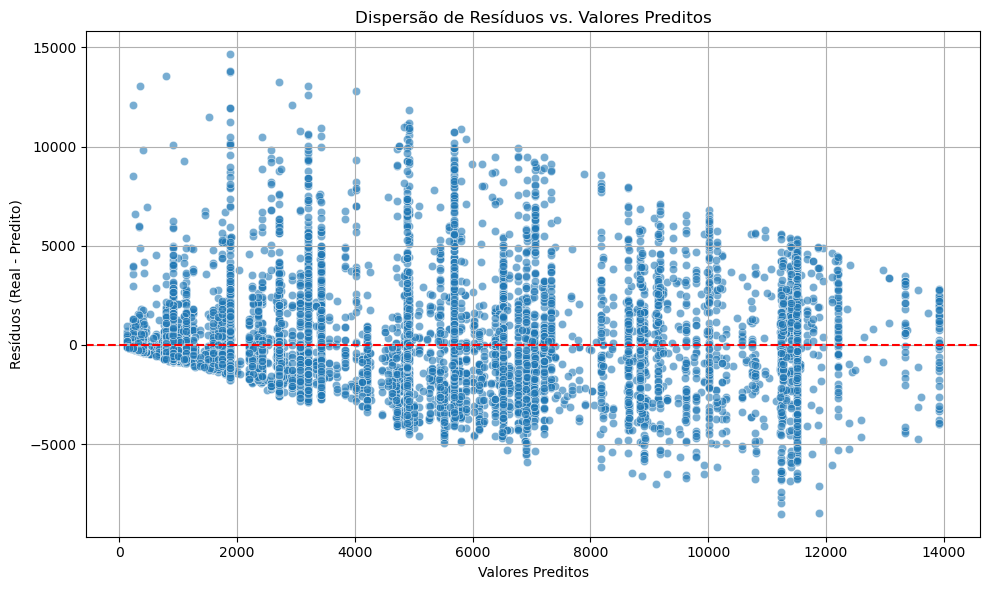

'\n\n# RESIDUOS\nOs residuos estão muito próximos quandos os seus valores são pequenos.\nPara os valores maiores o erro aumenta, mas ainda assim existe a concentração dos pequenos valores.\nEste modelo está apresentando heterocedasticidade atenuada, a suposição de linearidade para alcancar a\nhomocedasticidade não está sendo atendido.\n\n\n# MEXER NA BASE REMOVER OUTLIERS\n-------OPÇÃO EM STANDBY, AINDA NÃO VERIFICADA.\nVamos remover os valores acima do 3 quartil, deixando apenas quem é menor ou igual.\ndesta forma poderemos ter mais assertividade e dispersão homocedastica dos residuos.\n\n'

In [23]:
########################################################################

# GRAFICO REAL VS RESIDUOS


########################################################################



# 1. Calcular os resíduos
residuos = y_test - y_pred_test

# 2. Plotar gráfico de resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Dispersão de Resíduos vs. Valores Preditos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos (Real - Predito)")
plt.grid(True)
plt.tight_layout()
plt.show()


'''

# RESIDUOS
Os residuos estão muito próximos quandos os seus valores são pequenos.
Para os valores maiores o erro aumenta, mas ainda assim existe a concentração dos pequenos valores.
Este modelo está apresentando heterocedasticidade, pois a sua dispersão dos erros não é constante....
Com isso, a suposição de linearidade para alcancar a homocedasticidade não está sendo atendido.


# MEXER NA BASE REMOVER OUTLIERS
-------OPÇÃO EM STANDBY, AINDA NÃO VERIFICADA.
Vamos remover os valores acima do 3 quartil, deixando apenas quem é menor ou igual.
desta forma poderemos ter mais assertividade e dispersão homocedastica dos residuos.

'''

In [24]:
'''

####################################################################

A TABELA DE PREDIÇÕES AJUDA A ENTENDER O COMPORTAMENTO DO MODELO, PERMITE
VISUALIZAR AS COLUNAS DE VALORES REAIS vs VALORES PREDITOS.S

'''


# TABELA FINAL DE RESULTADOS:
y_true = base_cenario['TU'].values
y_pred = pred_cenario_um


resultados = pd.DataFrame({
    'Valor Real': y_true,
    'Valor Predito': y_pred,
    'Erro Absoluto': abs(y_true - y_pred),
    'Erro Percentual (%)': abs((y_true - y_pred) / y_true) * 100
})

# Visualizando as primeiras linhas
print(resultados.info())
print(resultados.head(50))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1901 entries, 0 to 1900
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Valor Real           1901 non-null   int32  
 1   Valor Predito        1901 non-null   float64
 2   Erro Absoluto        1901 non-null   float64
 3   Erro Percentual (%)  1901 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 52.1 KB
None
    Valor Real  Valor Predito  Erro Absoluto  Erro Percentual (%)
0        23454       11500.30       11953.70                50.97
1         9093        7335.23        1757.77                19.33
2        11071       11413.63         342.63                 3.09
3        13431       11481.84        1949.16                14.51
4         7544        7335.23         208.77                 2.77
5         6076        6454.11         378.11                 6.22
6         4756        5753.50         997.50                20.97
7         

In [ ]:
'''

HIPÓTESE NULA:
    SERÁ QUE MEU MODELO CONSEGUE EXPLICAR AS TONELADAS TRANSPORTADAS
    APENAS COM AS DEMAIS COLUNAS DO NOSSO DATASET ?

REPSOSTA:
    A HIPÓTESE NULA FOI ACEITA, POIS O MODELO SÓ EXPLICA 65% DOS DADOS E APRESENTA HETEROCEDASTICIDADE,
    QUANTO MAIOR OS VALORES REAIS, MAIOR FOI O ERRO DO MEU MODELO.


'''